![RFM Analysis.png](<attachment:RFM Analysis.png>)
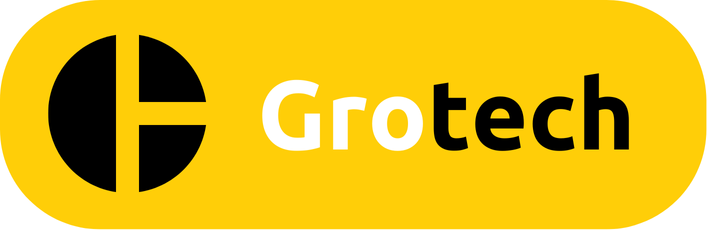

# Latar Belakang

Grotech menyediakan berbagai alat berat seperti *excavator*, *crane*, dan *forklift* yang dirancang untuk efisiensi dan ketahanan tinggi yang memenuhi standar kualitas terbaik. Dalam mendukung kebutuhan teknologi, Grotech menghadirkan sistem manajemen proyek berbasis digital dan alat pemantauan real-time untuk meningkatkan produktivitas. Layanan konsultasi juga tersedia, mencakup pelatihan operator, dukungan teknis, dan desain arsitektural yang disesuaikan dengan kebutuhan klien.

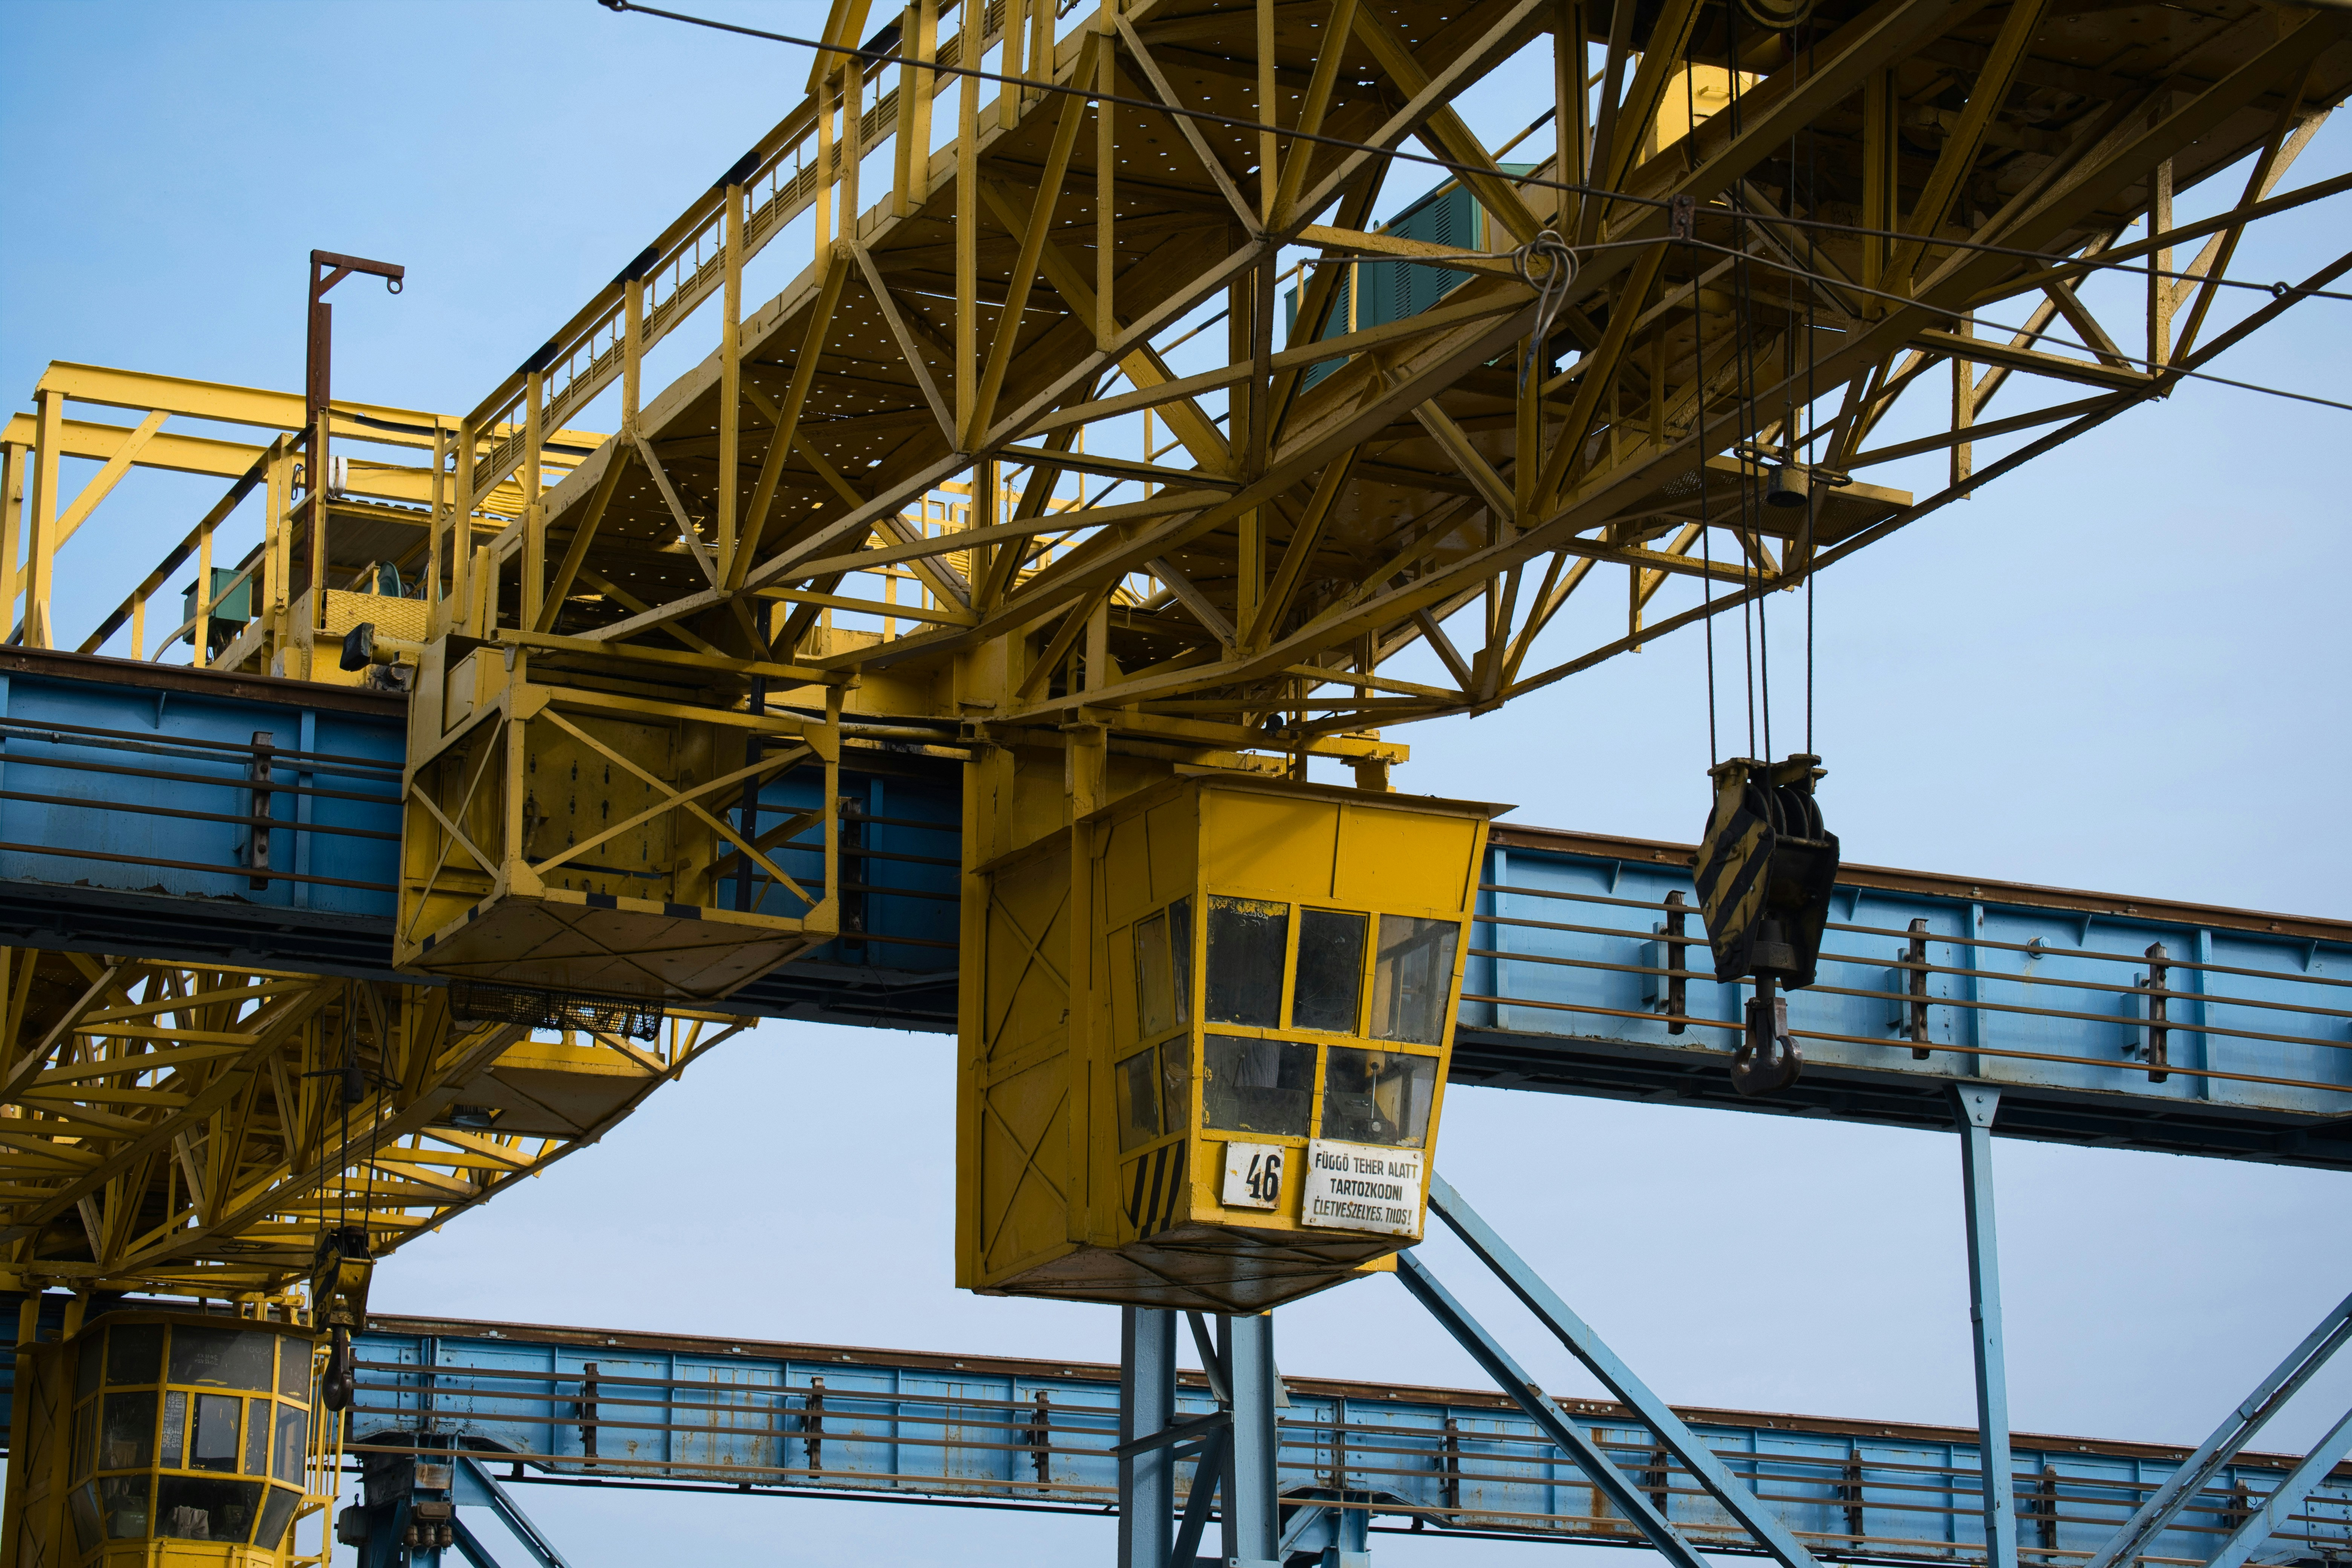

## Pernyataan Masalah

Grotech menghadapi kesulitan dalam **menentukan pendekatan pemasaran yang tepat karena kurangnya segmentasi klien** yang jelas, sehingga kampanye pemasaran kurang efektif dalam menjangkau target audiens.

Sebagai seorang *data analyst*, kita akan mencoba menjawab pertanyaan berikut:

> Bagaimana perusahaan dapat mengidentifikasi dan memahami pola perilaku klien, mengelompokkan Klien berdasarkan nilai mereka (Monetary), frekuensi pembelian (Frequency), dan waktu pembelian terakhir (Recency), untuk mengoptimalkan strategi pemasaran dan retensi serta meningkatkan profitabilitas melalui segmentasi berbasis RFM?

# Data
Untuk menjawab pertanyaan di atas, kita akan menganalisa data pelanggang yang sudah dikumpulkan oleh perusahaan. Dataset dapat diakses [di sini](https://www.kaggle.com/datasets/zahrazolghadr/rfm-dataset). 

In [116]:
# import library dan modul yang diperlukan
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

import warnings
warnings.filterwarnings('ignore')

Dataset ini berisi data transaksi, Dataset ini dirancang untuk menganalisis pola pembelian dan membantu dalam pengambilan keputusan bisnis strategis.


## Informasi Dataset
Dataset ini mencakup informasi sebagai berikut:
- **`ID`**: Nomor identifikasi unik untuk setiap pelanggan.
- **`Date`**: Tanggal transaksi yang dilakukan dalam format YYYYMMDD.
- **`Monetary`**: Nilai transaksi yang dilakukan dalam satuan mata uang tertentu.
- **`Gender`**: Jenis kelamin pelanggan (misalnya, pria atau wanita).


In [69]:
df = pd.read_csv('aggregate.csv', parse_dates=['Date'], dtype={'ID': object})
df

ID       Date  Monetary Gender
0     245114 2014-08-22    469000      F
1     245135 2014-08-12     10000      F
2     245135 2014-08-04     50000      F
3     245135 2014-08-25     10000      F
4     245135 2014-08-22     10000      F
...      ...        ...       ...    ...
9995  382961 2014-08-22     10000      M
9996  382961 2014-08-25     50000      M
9997  382961 2014-08-26     20000      M
9998  382961 2014-08-26     10000      M
9999  382961 2014-08-22     10000      M

[10000 rows x 4 columns]

## Data Understanding and Cleaning
Sebelum masuk ke dalam analisis, kita perlu mengenal dataset kita lebih jauh dalam tahapan *data understanding*. Dari proses ini, kita akan tahu anomali-anomali apa saja yang terdapat di dalam dataset kita dan perlu ditangani dalam tahapan *data cleaning*. Setiap penangan anomali yang dilakukan, akan disertai dengan justifikasi langkah yang diambil, baik secara *domain knowledge* maupun secara statistik.

In [70]:
print(f'Jumlah baris dan kolom di dataset df adalah {df.shape}')
df.info()

Jumlah baris dan kolom di dataset df adalah (10000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        10000 non-null  object        
 1   Date      10000 non-null  datetime64[ns]
 2   Monetary  10000 non-null  int64         
 3   Gender    10000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 312.6+ KB


In [71]:
pd.set_option('display.float_format', '{:.2f}'.format)
display(df.describe(), df.describe(include='object'))

Date    Monetary
count                          10000    10000.00
mean   2014-07-31 05:56:23.999999744    80097.60
min              2014-06-28 00:00:00     2000.00
25%              2014-07-11 00:00:00    10000.00
50%              2014-08-01 00:00:00    20000.00
75%              2014-08-19 00:00:00    20000.00
max              2014-08-27 00:00:00 14700000.00
std                              NaN   459154.52

ID Gender
count    10000  10000
unique    2089      2
top     366147      M
freq        66   9814

In [72]:
# Mengecek total duplicate values dalam DataFrame
total_duplicates = df.duplicated().sum()

# Kondisional untuk mengecek dan menampilkan pesan yang sesuai
if total_duplicates > 0:
    print("\nTotal nilai yang merupakan duplikat dalam DataFrame:", total_duplicates)
else:
    print("\nTidak ada data duplikat dalam DataFrame.")


Total nilai yang merupakan duplikat dalam DataFrame: 1880


In [73]:
missing_values = df.isnull().sum()
missing_percentage = round((missing_values / len(df)) * 100, 2)

missing_info = pd.DataFrame({
    'Number of Missing Value': missing_values,
    'Percentage of Missing Value': missing_percentage
}).sort_values(by='Percentage of Missing Value', ascending=False)

missing_info_filtered = missing_info[missing_info['Number of Missing Value'] > 0]

print("Informasi Missing Values:")
print(missing_info_filtered)

print(missing_values.sum())

Informasi Missing Values:
Empty DataFrame
Columns: [Number of Missing Value, Percentage of Missing Value]
Index: []
0


Secara umum, kita bisa melihat bahwa:
- dataset ini memiliki 4 kolom dan 10.000 baris
- dataset ini tidak memiliki kolom null sama sekali
- terdapat 1880 data duplikat di dalam dataset
- dataset mengandung kolom Monetary yang berpotensial redundan

**Mengatasi data duplikat**

Kami mengidentifikasi duplikasi dalam dataset dengan menggunakan metode deteksi duplikasi berdasarkan seluruh kolom/fitur yang ada. Data yang duplikat adalah baris yang memiliki nilai yang sama persis pada semua kolom. Data duplikat ini layak untuk dihilangkan karena kami hanya ingin setiap pembelian unik.

In [74]:
df = df.drop_duplicates()
print("Jumlah baris setelah menghapus duplikasi:", df.shape[0])

Jumlah baris setelah menghapus duplikasi: 8120


**Rename Column `Monetary`**

Untuk mencegah kolom yang redundan kita akan merubah kolom `Monetary` menjadi `Invoice Amount`, agar dapat dipahami

In [75]:
df = df.rename(columns={'Monetary': 'Invoice Amount'})
df

ID       Date  Invoice Amount Gender
0     245114 2014-08-22          469000      F
1     245135 2014-08-12           10000      F
2     245135 2014-08-04           50000      F
3     245135 2014-08-25           10000      F
4     245135 2014-08-22           10000      F
...      ...        ...             ...    ...
9993  382961 2014-08-26           10000      M
9994  382961 2014-08-27           50000      M
9995  382961 2014-08-22           10000      M
9996  382961 2014-08-25           50000      M
9997  382961 2014-08-26           20000      M

[8120 rows x 4 columns]

### Data yang sudah bersih
Kita sudah selesai membersihkan data kita, sekarang, mari kita lihat sekilas informasi dari data yang sudah kita bersihkan

In [76]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(8120, 4)


dataFeatures        dataType  null  unique  \
0              ID          object     0    2089   
1            Date  datetime64[ns]     0      24   
2  Invoice Amount           int64     0     549   
3          Gender          object     0       2   

                                        uniqueSample  
0                                   [355225, 286778]  
1  [2014-08-22T00:00:00.000000000, 2014-07-28T00:...  
2                                    [238000, 85000]  
3                                             [M, F]

Sebelum dibersihkan, kita memiliki 10000 baris data, sekarang kita memiliki 8120 baris. Sekitar 1880 baris data yang duplikat dihapus.

### Exploratory Data Analysis (EDA)

EDA dilakukan untuk menemukan insight awal tentang data tersebut seeblum melakukan RFM analysis.

In [173]:
def y_fmt(x, pos): 
    if x >= 1e6: 
        return f'{x*1e-6:.1f}M' 
    elif x >= 1e3: 
        return f'{x*1e-3:.1f}K' 
    else: return f'{x:.0f}'

**Melihat Distribusi Data**


Statistik Deskriptif Invoice Amount:


count        8120.000000
mean        94419.458128
std        508350.493828
min          2000.000000
25%         10000.000000
50%         20000.000000
75%         20000.000000
max      14700000.000000
Name: Invoice Amount, dtype: object


Distribusi Gender:
Gender
M   98.14
F    1.86
Name: proportion, dtype: float64 %


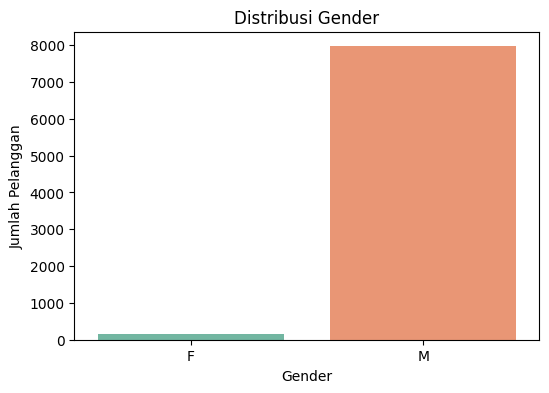

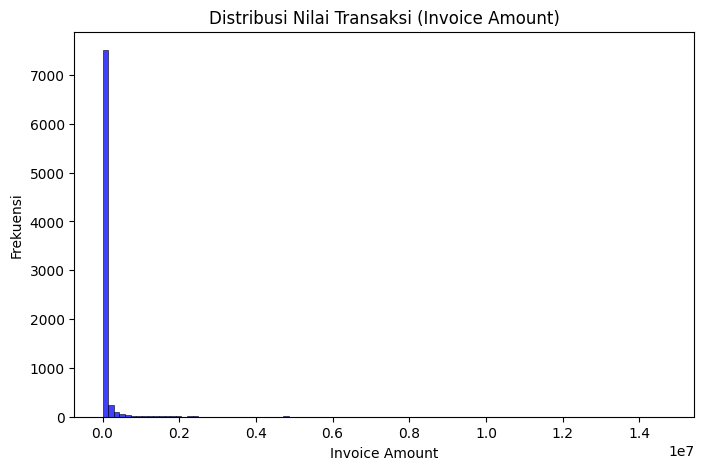

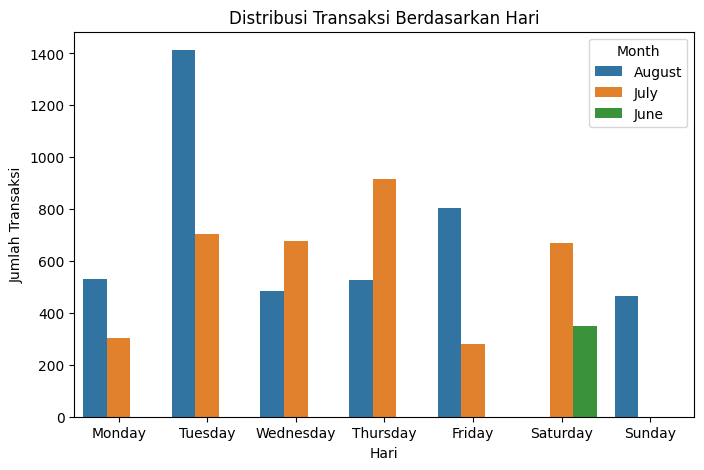

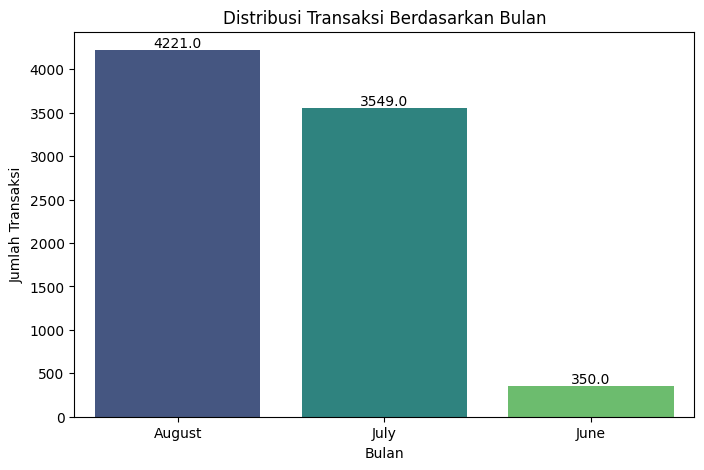


Rata-rata Nilai Transaksi per Gender:
Gender
F   56556.29
M   95136.91
Name: Invoice Amount, dtype: float64


In [153]:
import matplotlib.ticker as ticker

print("\nStatistik Deskriptif Invoice Amount:")
display(df['Invoice Amount'].describe().apply(lambda x: format(x, 'f')))

print("\nDistribusi Gender:")
gender_dist = str(df['Gender'].value_counts(normalize=True) * 100) +" %"
print(gender_dist)

plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=df, palette='Set2')
plt.title('Distribusi Gender')
plt.xlabel('Gender')
plt.ylabel('Jumlah Pelanggan')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['Invoice Amount'], bins=100, color='blue')
plt.title('Distribusi Nilai Transaksi (Invoice Amount)')
plt.xlabel('Invoice Amount')
plt.ylabel('Frekuensi')
plt.show()

df['Date'] = pd.to_datetime(df['Date'])

df['DayOfWeek'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
    
plt.figure(figsize=(8, 5))
sns.countplot(x='DayOfWeek', data=df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], hue='Month')
plt.title('Distribusi Transaksi Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Transaksi')
plt.show()

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Month', data=df, palette='viridis')
plt.title('Distribusi Transaksi Berdasarkan Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Transaksi')

for p in ax.patches:
    height = p.get_height()
    
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position (middle of the bar)
        height + 0.1,                   # Y position (slightly above the bar)
        f'{height}',                    # The number of transactions
        ha='center',                    # Horizontal alignment
        va='bottom',                    # Vertical alignment
        fontsize=10,                    # Font size for annotation
        color='black'                   # Color of the annotation text
    )
plt.show()

avg_monetary = df.groupby('Gender')['Invoice Amount'].mean()
print("\nRata-rata Nilai Transaksi per Gender:")
print(avg_monetary)

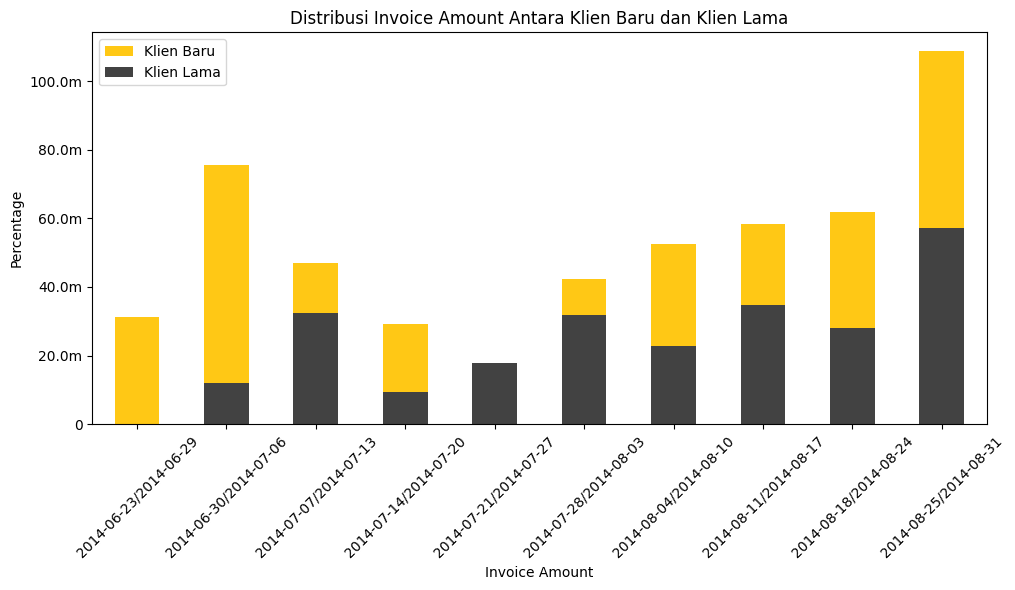

In [ ]:
import matplotlib.ticker as ticker
copy_df = df.copy()
copy_df['Week'] = pd.to_datetime(copy_df['Date']).dt.to_period('W').astype(str)
copy_df['First_Purchase_Week'] = copy_df.groupby('ID')['Week'].transform('min')

copy_df['Is_New'] = copy_df['Week'] == copy_df['First_Purchase_Week']

monetary_per_week = copy_df.groupby(['Week', 'Is_New'])['Invoice Amount'].sum().unstack(fill_value=0)

monetary_per_week['Total'] = monetary_per_week.sum(axis=1)
client_per_week_percentage = monetary_per_week.div(monetary_per_week['Total'], axis=0) * 100

plt.figure(figsize=(10, 6))
monetary_per_week[True].plot(kind='bar', stacked=True, color='#ffc815', label='Klien Baru', ax=plt.gca())
monetary_per_week[False].plot(kind='bar', stacked=True, color='#424242', label='Klien Lama', ax=plt.gca())

plt.title('Distribusi Invoice Amount Antara Klien Baru dan Klien Lama')
plt.xlabel('Invoice Amount')
plt.ylabel('Percentage')
plt.xticks(rotation=45) 
plt.legend(['Klien Baru', 'Klien Lama'], loc='upper left')
plt.tight_layout()
ax = plt.gca() 
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
plt.show()


Is_New                 False   True  Total
Week                                      
2014-06-23/2014-06-29   0.00 100.00 100.00
2014-06-30/2014-07-06  38.78  61.22 100.00
2014-07-07/2014-07-13  66.44  33.56 100.00
2014-07-14/2014-07-20  67.75  32.25 100.00
2014-07-21/2014-07-27  75.41  24.59 100.00
2014-07-28/2014-08-03  76.71  23.29 100.00
2014-08-04/2014-08-10  73.40  26.60 100.00
2014-08-11/2014-08-17  72.52  27.48 100.00
2014-08-18/2014-08-24  77.01  22.99 100.00
2014-08-25/2014-08-31  78.25  21.75 100.00

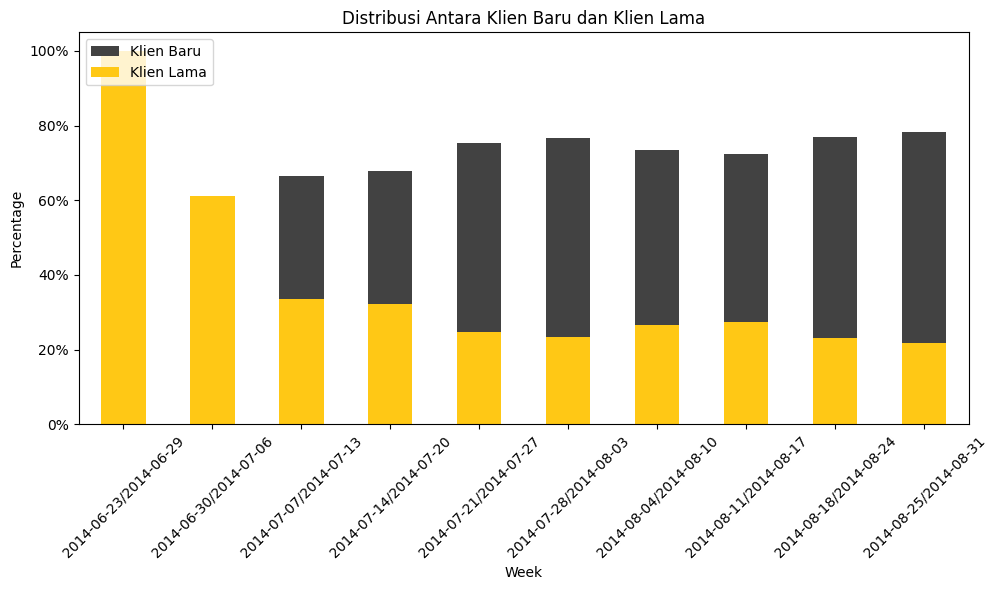

In [151]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

copy_df = df.copy()

copy_df['Week'] = pd.to_datetime(copy_df['Date']).dt.to_period('W').astype(str)
copy_df['First_Purchase_Week'] = copy_df.groupby('ID')['Week'].transform('min')

copy_df['Is_New'] = copy_df['Week'] == copy_df['First_Purchase_Week']

client_per_week = copy_df.groupby(['Week', 'Is_New'])['ID'].count().unstack(fill_value=0)

client_per_week['Total'] = client_per_week.sum(axis=1)

client_per_week_percentage = client_per_week.div(client_per_week['Total'], axis=0) * 100

display(client_per_week_percentage)

client_per_week_percentage['Klien_Lama'] = client_per_week_percentage[False]
client_per_week_percentage['Klien_Baru'] = client_per_week_percentage[True]

plt.figure(figsize=(10, 6))

# Plot stacked bars
client_per_week_percentage['Klien_Lama'].plot(kind='bar', stacked=True, color='#424242', label='Klien Lama', ax=plt.gca())
client_per_week_percentage['Klien_Baru'].plot(kind='bar', stacked=True, color='#ffc815', label='Klien Baru', ax=plt.gca())

plt.title('Distribusi Antara Klien Baru dan Klien Lama')
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.legend(['Klien Baru', 'Klien Lama'], loc='upper left')

plt.tight_layout()

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}%'))

plt.show()


**Mencari Outliers**

Terdapat outliers sebanyak: 1861 (22.918719211822662%)


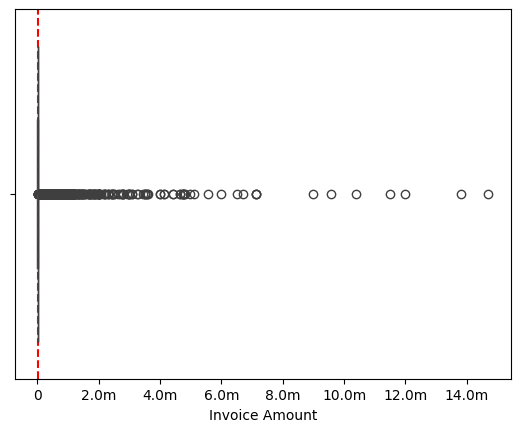

In [ ]:

ax = plt.gca() 
ax.xaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
sns.boxplot(x='Invoice Amount', data=df)

q1 = df['Invoice Amount'].quantile(0.25) 
q3 = df['Invoice Amount'].quantile(0.75)  
iqr = q3 - q1 
lowerwhisker = q1 - (1.5 * iqr) 
upperwhisker = q3 + (1.5 * iqr) 
extreme_lower_bound = q1 - 3 * iqr 
extreme_upper_bound = q3 + 3 * 99
plt.axvline(x=extreme_upper_bound, color='r', linestyle='--', label='Extreme Upper Bound (3 * IQR)')

outliers = df[(df['Invoice Amount'] < lowerwhisker) | (df['Invoice Amount'] > upperwhisker)]
print("Terdapat outliers sebanyak: " + str(len(outliers)) + " (" + str(len(outliers)  /  len(df)* 100) + "%)")

Insight: 
- Transaksi banyak terjadi pada bulan `Agustus`, sebanyak 4221
- Karena kolom `Gender` proposi `Male` terlalu banyak sebesar 98%, maka kolom `Gender` tidak relevan untuk di jadikan kelompok RFM, bisa berpotensi bias
- Terdapat outliers di kolom `Monetary` sebesar 22% yang bisa mempengaruhi score RFM

## RFM Analysis

### Kalkulasi Kolom

Pada step kali ini kita akan menambahkan beberapa kolom untuk menghitung masing-masing score dari `Recency`, `Frequency`, `Monetary` yaitu:
- `Recency`: Jarak antara transaksi hari terakhir dengan hari ini (kita anggap hari ini adalah tanggal maksimal dari dataset ini + 1)
- `Frequency`: Seberapa sering klien melakukan transaksi
- `Monetary`: Seberapa besar jumlah total transaksi

In [100]:
reference_date = df['Date'].max() + dt.timedelta(days=1)
rfm_df = df.groupby('ID').agg(
    Last_Purchase_Date=('Date', 'max'), 
    Frequency=('ID', 'count'),        
    Monetary=('Invoice Amount', 'sum')  
).reset_index()


rfm_df['Recency'] = (reference_date - rfm_df['Last_Purchase_Date']).dt.days


rfm_df = rfm_df[['ID', 'Recency', 'Frequency', 'Monetary']]

rfm_df.sort_values('Monetary', ascending=False)

ID  Recency  Frequency  Monetary
293   263337        3          4  27289000
480   274554       30          5  24360000
1644  360228       33          2  18560000
871   297855        6          3  15600000
232   260231       16          4  15280000
...      ...      ...        ...       ...
1053  309431        2          1     10000
435   272179        1          1     10000
936   302270        3          1      7000
1277  324075        6          1      3000
313   264672       58          1      2000

[2089 rows x 4 columns]

**Menentukan Outliers yang ingin di handle**
- Kita hanya menangani outliers hanya pada `Frequency` dan `Monetary` untuk memastikan data yang lebih realistis tentang seberapa sering dan banyak jumlah total transaksi.
- Biarkan `Recency` karena outliers di `Recency` tetap memberikan wawasan tentang keterlibatan Klien dan tidak terlalu mengganggu hasil analisis.

Terdapat outliers sebanyak: 240 (11.488750598372427%)


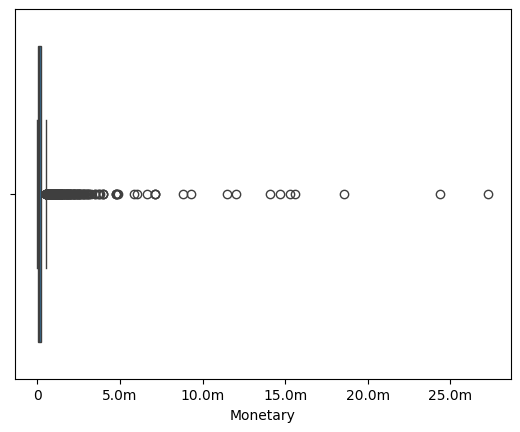

In [111]:
ax = plt.gca() 
ax.xaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
sns.boxplot(x='Monetary', data=rfm_df)

q1 = rfm_df['Monetary'].quantile(0.25) 
q3 = rfm_df['Monetary'].quantile(0.75)  
iqr = q3 - q1 
lowerwhisker = q1 - (1.5 * iqr) 
upperwhisker = q3 + (1.5 * iqr) 
# Filtering out the outliers
outliers = rfm_df[(rfm_df['Monetary'] < lowerwhisker) | (rfm_df['Monetary'] > upperwhisker)]
print("Terdapat outliers sebanyak: " + str(len(outliers)) + " (" + str(len(outliers)  /  len(rfm_df)* 100) + "%)")

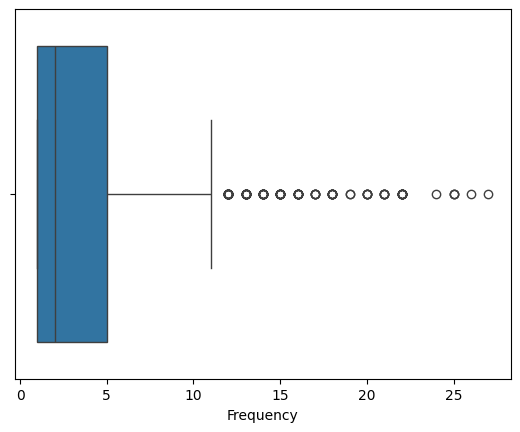

Terdapat outliers sebanyak: 132 (6.318812829104835%)


In [104]:
q1_freq = rfm_df['Frequency'].quantile(0.25) 
q3_freq = rfm_df['Frequency'].quantile(0.75)  
iqr_freq = q3_freq - q1_freq 
lowerwhisker_freq = q1_freq - (1.5 * iqr_freq) 
upperwhisker_freq = q3_freq + (1.5 * iqr_freq) 
sns.boxplot(x='Frequency', data=rfm_df)
plt.show()
outliers_freq = rfm_df[(rfm_df['Frequency'] < lowerwhisker_freq) | (rfm_df['Frequency'] > upperwhisker_freq)]
print("Terdapat outliers sebanyak: " + str(len(outliers_freq)) + " (" + str(len(outliers_freq)  /  len(rfm_df)* 100) + "%)")

## Menentukan Frequency, Monetary, Recency Score
Setelah menentukan outliers yang ingin di handle, kita akan menghitung skor masing-masing dari `Frequency`, `Monetary`, `Recency` tanpa memasukan outliers untuk pembagian skor `Frequency` dan `Monetary`

In [113]:
def equal_width_binning(data, n_bins):
    # Menggunakan np.linspace untuk menghitung batas bin secara merata dari nilai minimum ke maksimum
    bin_edges = np.linspace(data.min(), data.max(), n_bins + 1)
    
    # Menggunakan pd.cut untuk membagi data menjadi bin berdasarkan bin_edges yang telah dihitung
    # 'labels=False' berarti hasilnya adalah label numerik untuk setiap bin
    binned_data = pd.cut(data, bins=bin_edges, include_lowest=True, labels=False)
    
    # Mengembalikan hasil binned data
    return binned_data

# Fungsi utama untuk menghitung skor RFM (Recency, Frequency, Monetary)
def rfm_score(rfm_df, n_bins=5, upperwhisker_freq=None, upperwhisker=None):

    # Menghitung bin untuk masing-masing kolom RFM menggunakan equal-width binning
    recency_bins = equal_width_binning(rfm_df['Recency'], n_bins)
    frequency_bins = equal_width_binning(rfm_df['Frequency'], n_bins)
    monetary_bins = equal_width_binning(rfm_df['Monetary'], n_bins)
    
    # Memberikan skor pada setiap pelanggan untuk kolom 'Frequency' dan 'Monetary'
    # Skor ditentukan dengan menambahkan 1 karena label dimulai dari 0
    frequency_score = [f + 1 for f in frequency_bins]
    monetary_score = [m + 1 for m in monetary_bins]

    # Menambahkan kolom skor untuk Frequency dan Monetary pada dataframe
    rfm_df['Frequency_Score'] = frequency_score
    rfm_df['Monetary_Score'] = monetary_score

    # Jika ada outliers pada kolom 'Frequency', set skor menjadi 5
    rfm_df.loc[rfm_df['Frequency'] > upperwhisker_freq, 'Frequency_Score'] = 5
    
    # Jika ada outliers pada kolom 'Monetary', set skor menjadi 5
    rfm_df.loc[rfm_df['Monetary'] > upperwhisker, 'Monetary_Score'] = 5

    # Menentukan skor Recency, dimana semakin kecil nilai Recency (semakin baru transaksi), semakin tinggi skornya
    rfm_df['Recency_Score'] = [n_bins - r for r in recency_bins]

    # Mengumpulkan skor akhir RFM (Recency, Frequency, Monetary) ke dalam dataframe baru
    rfm_scores_df = rfm_df[['ID', 'Recency_Score', 'Frequency_Score', 'Monetary_Score']]
    
    # Mengembalikan dataframe yang berisi skor RFM
    return rfm_scores_df


rfm_scores = rfm_score(rfm_df, 5, upperwhisker_freq, upperwhisker)
rfm_df_calculate = rfm_df.copy()
rfm_df_calculate

ID  Recency  Frequency  Monetary  Frequency_Score  Monetary_Score  \
0     245114        6          1    469000                1               1   
1     245135        3          4     80000                1               1   
2     245204        2          5     50000                1               1   
3     245238       14          2     70000                1               1   
4     245261        9          1    485000                1               1   
...      ...      ...        ...       ...              ...             ...   
2084  382576       14          6    140000                1               1   
2085  382741       16          2     40000                1               1   
2086  382785        3          7    110000                2               1   
2087  382940        2          4     40000                1               1   
2088  382961        1          5    140000                1               1   

      Recency_Score  
0                 5  
1                 5  
2                 5  
3                 4  
4                 5  
...             ...  
2084              4  
2085              4  
2086              5  
2087              5  
2088              5  

[2089 rows x 7 columns]

### Menghitung RFM Score

Kita akan mengkalkulasi RFM Score dari masing-masing score yang sudah di tentukan dengan bobot:
 1. `Frequency` sebesar 45%
 2. `Monetary` sebesar 35%
 3. `Recency` sebesar 20%

In [114]:
rfm_df_calculate['Recency_Score'] = pd.to_numeric(rfm_df_calculate['Recency_Score'], errors='coerce')
rfm_df_calculate['Frequency_Score'] = pd.to_numeric(rfm_df_calculate['Frequency_Score'], errors='coerce')
rfm_df_calculate['Monetary_Score'] = pd.to_numeric(rfm_df_calculate['Monetary_Score'], errors='coerce')

weight_recency = 0.2
weight_frequency = 0.45
weight_monetary = 0.35

rfm_df_calculate['RFM_Score'] = (
    rfm_df_calculate['Recency_Score'] * weight_recency +
    rfm_df_calculate['Frequency_Score'] * weight_frequency +
    rfm_df_calculate['Monetary_Score'] * weight_monetary
)

rfm_df_calculate

ID  Recency  Frequency  Monetary  Frequency_Score  Monetary_Score  \
0     245114        6          1    469000                1               1   
1     245135        3          4     80000                1               1   
2     245204        2          5     50000                1               1   
3     245238       14          2     70000                1               1   
4     245261        9          1    485000                1               1   
...      ...      ...        ...       ...              ...             ...   
2084  382576       14          6    140000                1               1   
2085  382741       16          2     40000                1               1   
2086  382785        3          7    110000                2               1   
2087  382940        2          4     40000                1               1   
2088  382961        1          5    140000                1               1   

      Recency_Score  RFM_Score  
0                 5       1.80  
1                 5       1.80  
2                 5       1.80  
3                 4       1.60  
4                 5       1.80  
...             ...        ...  
2084              4       1.60  
2085              4       1.60  
2086              5       2.25  
2087              5       1.80  
2088              5       1.80  

[2089 rows x 8 columns]

## Membuat Segmentasi

Karena kita menentukan bobot yang paling besar ada di `Frequency`, kemudian `Monetary` dan terakhir `Recency`. Maka kita akan membuat segmentasi secara ordinal sebagai berikut:
* `Champion`:
    - **Recency**: Tinggi – Baru-baru ini melakukan pembelian.
    - **Frequency**: Tinggi – Membeli secara konsisten.
    - **Monetary**: Tinggi – Membelanjakan jumlah besar atau sering.
    - **Karakteristik**: 
        Pelanggan yang sangat loyal, aktif, dan sering membeli dengan pengeluaran besar. Mereka adalah pelanggan setia yang selalu kembali dan sangat terlibat dengan merek.

* `Loyal Customer`
    - **Recency**: Tinggi – Baru-baru ini membeli, meskipun tidak sesering Champion.
    - **Frequency**: Sedang hingga Tinggi – Rutin membeli meskipun tidak seintens Champion.
    - **Monetary**: Sedang – Membelanjakan jumlah yang cukup besar tetapi tidak selalu.
    - **Karakteristik**:
        Pelanggan yang setia dengan produk dan merek, meskipun mereka mungkin tidak membeli sesering Champion. Mereka menunjukkan tingkat loyalitas yang konsisten.

* `Cannot Lose Them`
    - **Recency**: Sedang – Masih baru, tetapi tidak seaktif Champion atau Loyal Customer.
    - **Frequency**: Tinggi – Membeli sering, namun mungkin sedikit berkurang.
    - **Monetary**: Tinggi – Pembelian mereka signifikan, sangat bernilai bagi bisnis.

    - **Karakteristik**:
        Pelanggan yang sangat penting untuk dipertahankan karena kontribusi pendapatan mereka yang besar. Bisa saja mereka mulai menunjukkan tanda-tanda penurunan keterlibatan, namun mereka masih loyal.

* `Potential Loyalist`
    - **Recency**: Sedang – Baru-baru ini melakukan pembelian.
    - **Frequency**: Sedang – Membeli lebih jarang, tetapi ada potensi untuk lebih sering.
    - **Monetary**: Sedang – Pembelian mereka cukup besar, tetapi tidak konsisten.

    - **Karakteristik**:
        Pelanggan yang baru mulai menunjukkan tanda-tanda loyalitas. Mereka mungkin membeli dari merek Anda beberapa kali, namun belum mencapai frekuensi yang tinggi atau tingkat pengeluaran yang stabil. Mereka memiliki potensi untuk menjadi pelanggan loyal jika diberikan perhatian yang lebih.

* `Need Attention`
    - **Recency**: Sedang hingga Rendah – Sudah lama tidak membeli, namun baru-baru ini ada aktivitas.
    - **Frequency**: Rendah – Sering menunjukkan penurunan dalam frekuensi pembelian.
    - **Monetary**: Sedang hingga Rendah – Pengeluaran mulai menurun, tetapi tetap ada potensi.

    - **Karakteristik**:
        Pelanggan yang sebelumnya loyal, namun mulai menunjukkan penurunan dalam frekuensi pembelian dan pengeluaran. Mereka memerlukan perhatian untuk kembali terlibat dengan merek Anda, misalnya melalui promosi atau layanan khusus.

* `Promising`
    - **Recency**: Sedang hingga Tinggi – Baru-baru ini membeli produk untuk pertama kalinya atau dalam beberapa kesempatan.
    - **Frequency**: Sedang – Pembelian yang masih terbatas, tetapi ada tanda-tanda minat yang positif.
    - **Monetary**: Sedang – Pengeluaran mereka cukup baik, tetapi belum konsisten.

    - **Karakteristik**:
        Pelanggan yang baru saja memulai perjalanan mereka dengan merek Anda dan menunjukkan tanda-tanda positif untuk menjadi lebih sering membeli. Mereka dapat berkembang menjadi pelanggan loyal jika diberikan insentif yang tepat.

* `At Risk`
    - **Recency**: Rendah – Sudah cukup lama sejak pembelian terakhir mereka.
    - **Frequency**: Rendah – Terjadi penurunan signifikan dalam frekuensi pembelian.
    - **Monetary**: Sedang hingga Rendah – Pengeluaran menurun, meskipun masih lebih tinggi dibandingkan segmen "About to Sleep."

    - **Karakteristik**:
        Pelanggan yang berisiko besar untuk berhenti berbelanja atau berpindah ke kompetitor. Mereka telah menunjukkan penurunan yang jelas dalam frekuensi dan recency pembelian. Perlu ada upaya segera untuk mengembalikan mereka dengan penawaran atau komunikasi yang lebih personal.
    
* `About to Sleep`
    - **Recency**: Sangat Rendah – Sudah lama tidak melakukan pembelian.
    - **Frequency**: Sangat Rendah – Hampir tidak ada pembelian yang terjadi dalam periode waktu tertentu.
    - **Monetary**: Rendah – Pengeluaran mereka sangat rendah atau bahkan nol dalam periode waktu yang lama.

    - **Karakteristik**:
        Pelanggan yang hampir tidak terlibat lagi dengan merek. Mereka mungkin sudah lama tidak membeli atau bahkan tidak menunjukkan minat lagi. Mereka berada di ambang untuk berhenti berbelanja sama sekali, kecuali ada usaha besar untuk membangkitkan kembali minat mereka.

In [126]:
def classify_rfm_score(score):
    if score > 4.5:
        return 'Champion'
    elif score > 4:
        return 'Loyal Customer'
    elif score > 3.5:
        return 'Cannot Lose Them'
    elif score > 3:
        return 'Potential Loyalist'
    elif score > 2.5:
        return 'Need Attention'
    elif score > 2:
        return 'Promising'
    elif score > 1.5:
        return 'New Customers'
    elif score > 1:
        return 'At Risk'
    else:
        return 'About to Sleep'
    
rfm_df_calculate['Segment'] = rfm_df_calculate['RFM_Score'].apply(classify_rfm_score)
rfm_df_calculate.to_excel('segmen_final.xlsx')

display(rfm_df_calculate)

ID  Recency  Frequency  Monetary  Frequency_Score  Monetary_Score  \
0     245114        6          1    469000                1               1   
1     245135        3          4     80000                1               1   
2     245204        2          5     50000                1               1   
3     245238       14          2     70000                1               1   
4     245261        9          1    485000                1               1   
...      ...      ...        ...       ...              ...             ...   
2084  382576       14          6    140000                1               1   
2085  382741       16          2     40000                1               1   
2086  382785        3          7    110000                2               1   
2087  382940        2          4     40000                1               1   
2088  382961        1          5    140000                1               1   

      Recency_Score  RFM_Score        Segment  
0                 5       1.80  New Customers  
1                 5       1.80  New Customers  
2                 5       1.80  New Customers  
3                 4       1.60  New Customers  
4                 5       1.80  New Customers  
...             ...        ...            ...  
2084              4       1.60  New Customers  
2085              4       1.60  New Customers  
2086              5       2.25      Promising  
2087              5       1.80  New Customers  
2088              5       1.80  New Customers  

[2089 rows x 9 columns]

## Visualisasi Segmentasi


Setelah kita melkakukan segmentasi kita akan lanjut ke tahap berikutnya yaitu menvisualisasikan segmentasi menggunakan treemap dan bubble plot, agar kita mudah untuk menganalisanya

In [155]:
pd.DataFrame(rfm_df_calculate['Segment'].value_counts())

count
Segment                  
New Customers        1084
Promising             272
At Risk               240
Need Attention        173
About to Sleep        160
Potential Loyalist    128
Cannot Lose Them       20
Loyal Customer          6
Champion                6

Segment  count  Percentage
0       New Customers   1084       51.89
1           Promising    272       13.02
2             At Risk    240       11.49
3      Need Attention    173        8.28
4      About to Sleep    160        7.66
5  Potential Loyalist    128        6.13
6    Cannot Lose Them     20        0.96
7      Loyal Customer      6        0.29
8            Champion      6        0.29

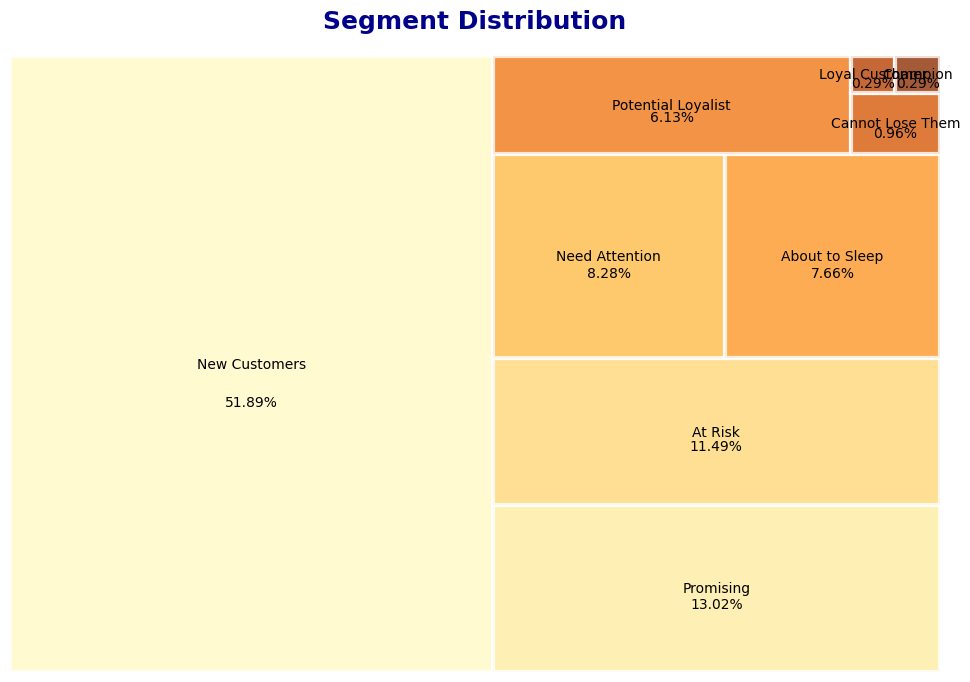

In [170]:
segment_counts = rfm_df_calculate['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'count']

colors = sns.color_palette('YlOrBr', len(segment_counts))
total_count = segment_counts['count'].sum()
segment_counts['Percentage'] = (segment_counts['count'] / total_count) * 100

plt.figure(figsize=(12, 8))
ax = squarify.plot(
    sizes=segment_counts['count'],
    label=segment_counts['Segment'],
    color=colors,
    alpha=0.8,
    edgecolor='white',
    linewidth=3
)

display(segment_counts)

for patch in ax.patches:
    # Ambil nilai persentase dari data, bukan dari label
    percentage = segment_counts.loc[segment_counts['Segment'] == patch.get_label(), 'Percentage'].values[0]

    # Hitung posisi tengah kotak
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_y() + patch.get_height() / 2  # Posisi tengah vertikal kotak


        # Jika bukan kata khusus, pertahankan posisi semula
    xytext = (x, y - 0.05 * patch.get_height())

    # Tambahkan anotasi tanpa panah
    plt.annotate(f"{percentage:.2f}%", xy=(x, y), xytext=xytext,
                 ha='center', va='top', fontsize=10)

plt.axis('off')

plt.title(
    'Segment Distribution',
    fontsize=18,
    fontweight='bold',
    color='darkblue',
    pad=20
)

# Display the plot
plt.show()

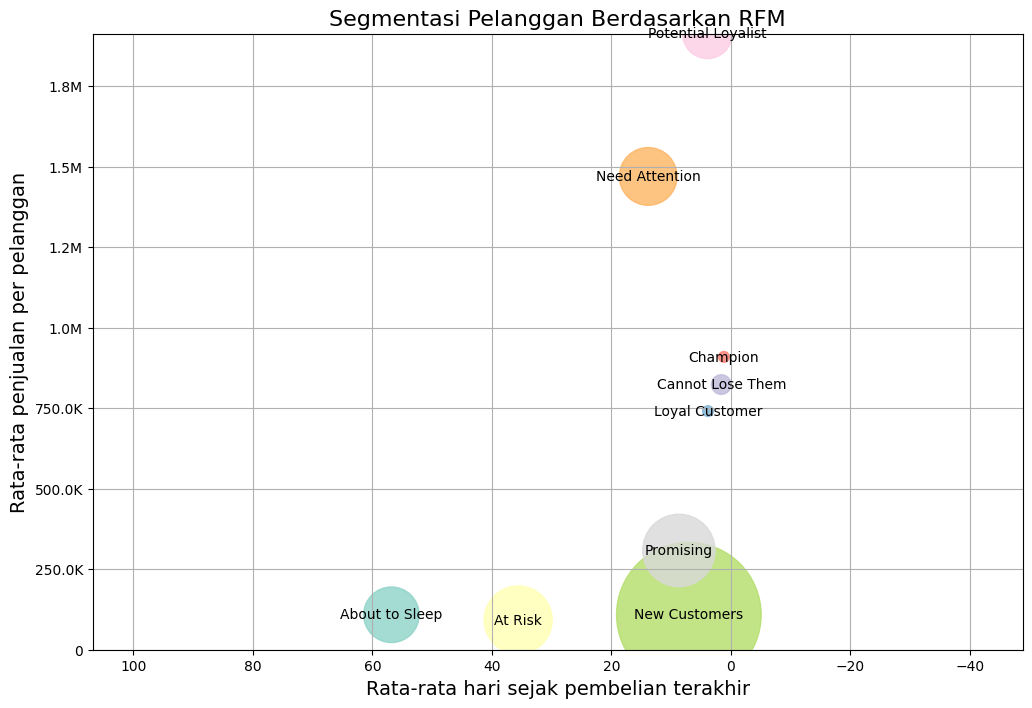

In [174]:
rdf = rfm_df_calculate.copy()

segment_summary = rdf.groupby('Segment').agg(
    avg_days_since_purchase=('Recency', 'mean'),
    avg_sales_per_customer=('Monetary', 'mean'),
    customer_count=('ID', 'count')
).reset_index()

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    segment_summary['avg_days_since_purchase'],
    segment_summary['avg_sales_per_customer'],
    s=segment_summary['customer_count'] * 10,
    c=sns.color_palette('Set3', len(segment_summary)),
    alpha=0.8
)

# Labeling the axes and title
plt.xlabel('Rata-rata hari sejak pembelian terakhir', fontsize=14)
plt.ylabel('Rata-rata penjualan per pelanggan', fontsize=14)
plt.title('Segmentasi Pelanggan Berdasarkan RFM', fontsize=16)
plt.grid(True)

for i, text in enumerate(segment_summary['Segment']):
    plt.annotate(
        text,
        (segment_summary['avg_days_since_purchase'][i], segment_summary['avg_sales_per_customer'][i]),
        ha='center',
        va='center'
    )

plt.gca().invert_xaxis()

plt.xlim(segment_summary['avg_days_since_purchase'].max() + 50, segment_summary['avg_days_since_purchase'].min() - 50)
plt.ylim(0, segment_summary['avg_sales_per_customer'].max() + 100)
ax = plt.gca() 
ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))
plt.show()


# Kesimpulan dan Rekomendasi 

Dari analisis yang telah dilakukan, kita akan mengklompokan dengan skala prioritas menjadi 4 kelompok:

* **Kelompok Terbesar** (`New Customer`) -> (51.89%)

    - New Customers menjadi fokus utama karena mereka merupakan kelompok terbesar (1.084 pelanggan), sehingga menjadi peluang signifikan untuk pertumbuhan bisnis. Berdasarkan data historis, persentase repeat customer cukup tinggi, yang menunjukkan adanya potensi kuat untuk mempertahankan kelompok ini jika diberikan treatment yang tepat.

    - Skor yang perlu ditingkatkan:
        - Frekuensi
        - Total Invoice
    
    - Strategi:
        - Memberikan treatment khusus untuk mengubah New Customers menjadi pelanggan loyal.
    
* **Kelompok Kritikal** (`Promising`, `At Risk` dan `About to sleep`) -> (32.17%)

    - Menangani Kelompok Kritikal (Promising dan At Risk) dengan baik tidak hanya mencegah churn tetapi juga meningkatkan loyalitas secara keseluruhan, menciptakan peluang jangka panjang untuk pertumbuhan bisnis.

    - Skor yang perlu ditingkatkan:
        - Frekuensi
        - Resensi
    
    - Strategi:
        - Gunakan program reaktivasi, pengingat produk, atau penawaran khusus untuk meningkatkan frekuensi dan resensi.

* **Kelompok High Value** (`Need Attention` dan `Potential Loyalist`) -> (14.41%)

    - Pelanggan dalam kategori High-Value menunjukkan potensi besar untuk menjadi pelanggan yang sangat loyal jika diberikan perhatian yang tepat. Need Attention sudah melakukan beberapa pembelian, tetapi membutuhkan rangsangan lebih lanjut untuk menjadi lebih loyal, sedangkan Potential Loyalist Potential Loyalist menunjukkan tanda-tanda bisa menjadi loyal, tetapi masih memerlukan dorongan untuk bergerak ke arah itu.

    - Skor yang perlu ditingkatkan:
        - Frekuensi
        - Total Invoice
    
    - Strategi:
        - Fokus pada membangun keterikatan melalui komunikasi untuk meningkatkan **frekuensi** dan tawarkan insentif untuk meningkatkan **total invoice**.
        - Program loyalty atau pengenalan produk lebih lanjut.

* **Kelompok Royal** (`Champion`, `Cannot Lose Them` dan `Loyalist`) -> (1.54%)

    - Kategori Royal adalah pelanggan yang sangat loyal dan memiliki kontribusi besar terhadap bisnis. Mereka adalah pelanggan yang sudah terbukti setia dan memberikan manfaat jangka panjang, baik melalui pembelian berulang, referensi, maupun testimoni.

    - Skor yang perlu ditingkatkan:
        - Frekuensi
        - Total Invoice
    
    - Strategi:
        - Berikan layanan premium dan penghargaan eksklusif untuk menjaga hubungan dan menjaga frekuensi dan tingkatkan total invoice dengan penawaran khusus atau produk tambahan.
        - Pertahankan komunikasi yang teratur untuk memperkuat hubungan dan memastikan mereka tetap terlibat.

Sebagai penutup, strategi segmentasi ini memberikan wawasan yang mendalam tentang cara mengelola dan mengoptimalkan hubungan dengan berbagai kelompok pelanggan berdasarkan perilaku dan potensi mereka. Dengan memprioritaskan kelompok-kelompok ini secara tepat dan memberikan treatment yang sesuai, kita dapat menciptakan pengalaman pelanggan yang lebih baik, meningkatkan loyalitas, serta mendorong pertumbuhan bisnis yang berkelanjutan. Setiap kelompok memiliki kebutuhan dan potensi yang berbeda, dan dengan pendekatan yang tepat, kita dapat mengubah peluang ini menjadi keuntungan jangka panjang yang signifikan.